In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression

df = pd.read_csv("/content/hitters.csv")
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


Overall picture

In [173]:
def check_df(dataframe, head):
  print("----- SHAPE -----")
  print(dataframe.shape)
  print("\n----- DTYPES -----")
  print(dataframe.dtypes)
  print("\n----- HEAD -----")
  print(dataframe.head(head))
  print("\n----- TAIL -----")
  print(dataframe.tail(head))
  print("\n----- NA -----")
  print(dataframe.isnull().sum())
  print("\n----- QUANTILES -----")
  print(dataframe.describe([0, 0.25, 0.50, 0.75, 1]).T)
  print("\n----- UNIQUE -----")
  print(df.nunique())
check_df(df, 5)

----- SHAPE -----
(322, 20)

----- DTYPES -----
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

----- HEAD -----
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks Lea

Capturing the numeric and categorical variables

In [174]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


 Analyzing the numerical and categorical variables.

     AtBat     Ratio
315      4  1.242236
216      4  1.242236
209      4  1.242236
278      3  0.931677
490      3  0.931677
..     ...       ...
420      1  0.310559
566      1  0.310559
641      1  0.310559
215      1  0.310559
631      1  0.310559

[247 rows x 2 columns]
----------------------------------------


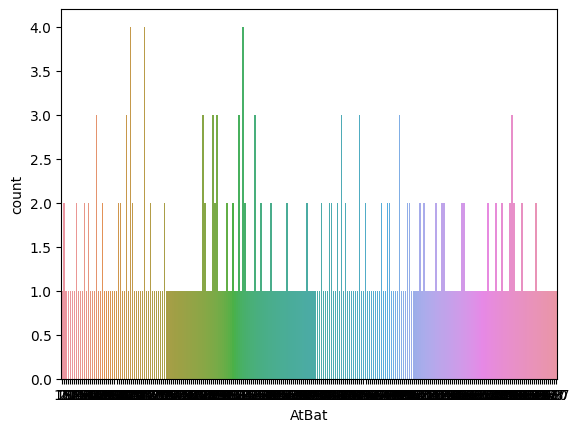

     Hits     Ratio
76      6  1.863354
70      6  1.863354
53      6  1.863354
54      5  1.552795
68      5  1.552795
..    ...       ...
223     1  0.310559
129     1  0.310559
116     1  0.310559
34      1  0.310559
172     1  0.310559

[144 rows x 2 columns]
----------------------------------------


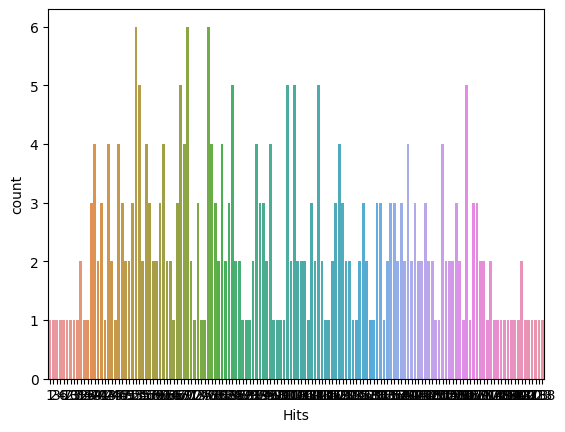

    HmRun     Ratio
4      22  6.832298
5      21  6.521739
8      20  6.211180
0      18  5.590062
6      18  5.590062
3      18  5.590062
1      17  5.279503
7      17  5.279503
2      16  4.968944
9      16  4.968944
16     12  3.726708
13     12  3.726708
12     10  3.105590
10     10  3.105590
20      9  2.795031
18      9  2.795031
21      8  2.484472
14      7  2.173913
31      6  1.863354
17      6  1.863354
11      6  1.863354
29      5  1.552795
23      5  1.552795
27      4  1.242236
19      4  1.242236
28      4  1.242236
24      4  1.242236
15      4  1.242236
22      3  0.931677
26      3  0.931677
33      2  0.621118
25      2  0.621118
34      1  0.310559
35      1  0.310559
40      1  0.310559
30      1  0.310559
----------------------------------------


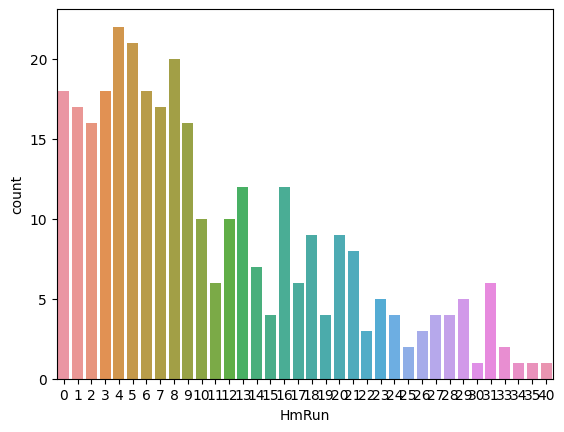

     Runs     Ratio
42     12  3.726708
24      9  2.795031
35      8  2.484472
67      8  2.484472
32      8  2.484472
..    ...       ...
13      1  0.310559
74      1  0.310559
108     1  0.310559
97      1  0.310559
101     1  0.310559

[96 rows x 2 columns]
----------------------------------------


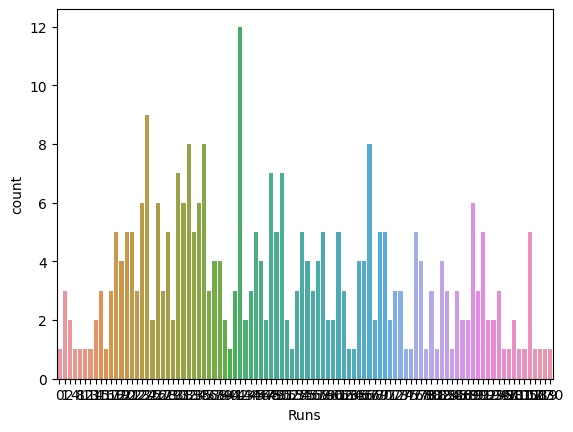

     RBI     Ratio
29    13  4.037267
36     9  2.795031
26     9  2.795031
44     8  2.484472
25     8  2.484472
..   ...       ...
117    1  0.310559
121    1  0.310559
102    1  0.310559
93     1  0.310559
100    1  0.310559

[103 rows x 2 columns]
----------------------------------------


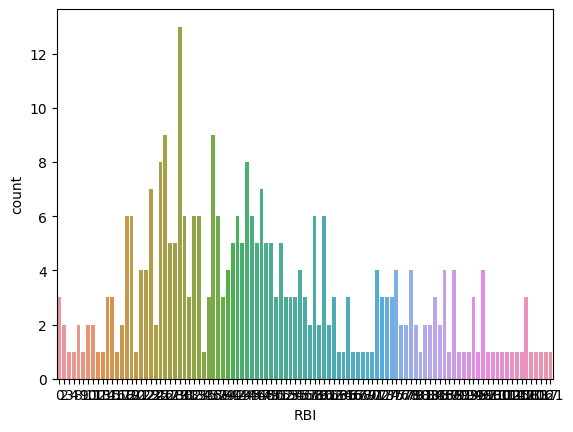

     Walks     Ratio
22      13  4.037267
30      12  3.726708
21      10  3.105590
15       9  2.795031
18       8  2.484472
..     ...       ...
97       1  0.310559
75       1  0.310559
48       1  0.310559
8        1  0.310559
105      1  0.310559

[89 rows x 2 columns]
----------------------------------------


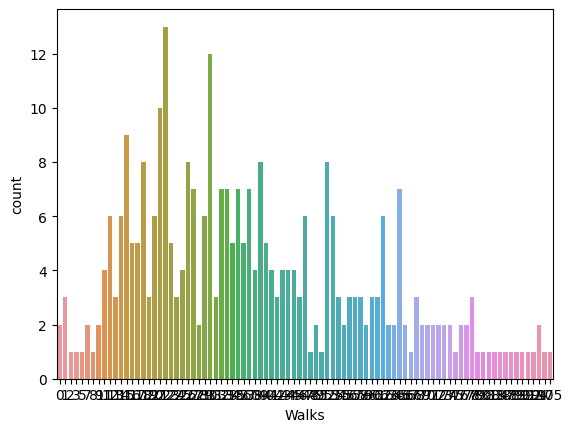

    Years      Ratio
4      36  11.180124
5      30   9.316770
6      30   9.316770
3      29   9.006211
2      25   7.763975
1      22   6.832298
7      21   6.521739
8      16   4.968944
9      15   4.658385
10     14   4.347826
12     14   4.347826
14     13   4.037267
13     12   3.726708
11     10   3.105590
15      9   2.795031
18      7   2.173913
17      7   2.173913
16      7   2.173913
20      2   0.621118
24      1   0.310559
23      1   0.310559
19      1   0.310559
----------------------------------------


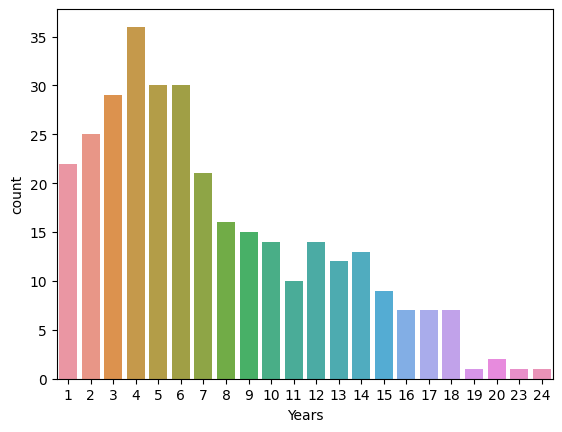

      CAtBat     Ratio
216        2  0.621118
41         2  0.621118
1928       2  0.621118
2331       2  0.621118
1258       2  0.621118
...      ...       ...
2129       1  0.310559
6100       1  0.310559
646        1  0.310559
994        1  0.310559
4908       1  0.310559

[314 rows x 2 columns]
----------------------------------------


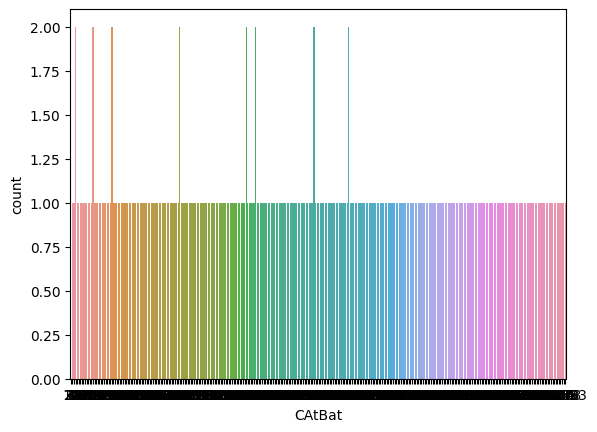

      CHits     Ratio
238       3  0.931677
408       3  0.931677
160       3  0.931677
715       3  0.931677
68        2  0.621118
...     ...       ...
728       1  0.310559
1910      1  0.310559
866       1  0.310559
568       1  0.310559
1457      1  0.310559

[288 rows x 2 columns]
----------------------------------------


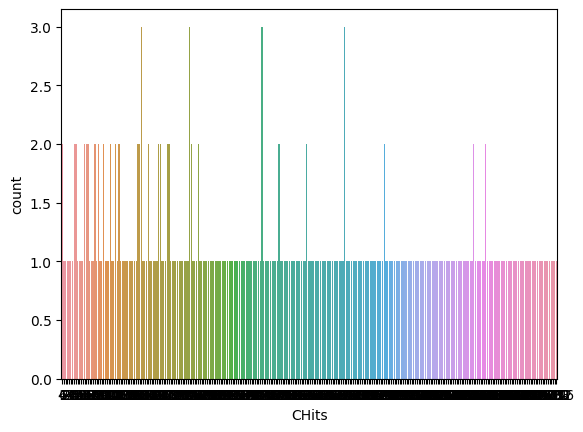

     CHmRun     Ratio
32       10  3.105590
12        9  2.795031
16        9  2.795031
1         9  2.795031
2         8  2.484472
..      ...       ...
59        1  0.310559
259       1  0.310559
107       1  0.310559
348       1  0.310559
110       1  0.310559

[146 rows x 2 columns]
----------------------------------------


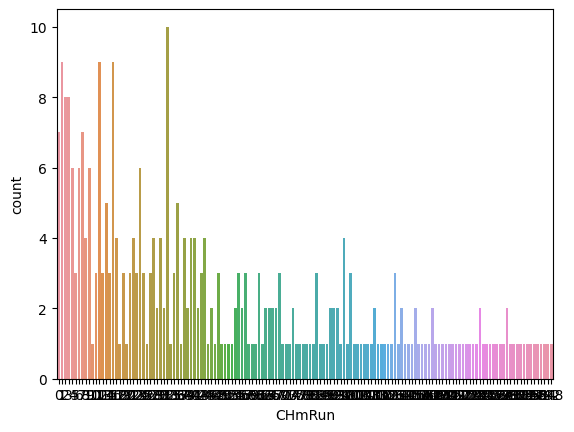

      CRuns     Ratio
20        5  1.552795
156       4  1.242236
32        3  0.931677
34        3  0.931677
379       3  0.931677
...     ...       ...
1070      1  0.310559
1172      1  0.310559
284       1  0.310559
703       1  0.310559
775       1  0.310559

[261 rows x 2 columns]
----------------------------------------


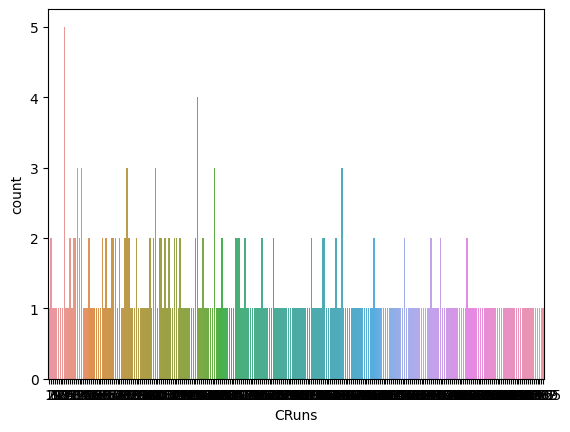

      CRBI     Ratio
32       5  1.552795
69       4  1.242236
46       4  1.242236
48       3  0.931677
401      3  0.931677
...    ...       ...
365      1  0.310559
955      1  0.310559
1267     1  0.310559
126      1  0.310559
357      1  0.310559

[262 rows x 2 columns]
----------------------------------------


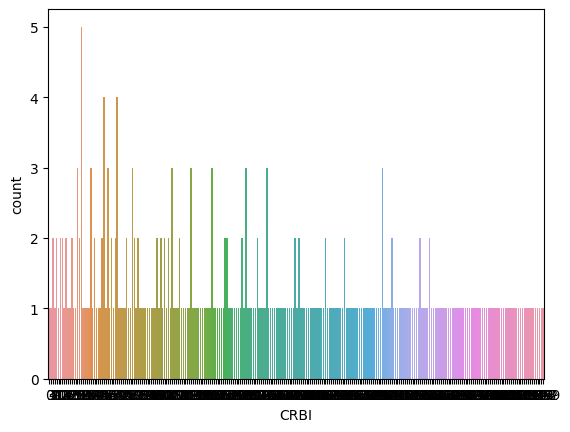

     CWalks     Ratio
55        5  1.552795
76        4  1.242236
14        3  0.931677
11        3  0.931677
174       3  0.931677
..      ...       ...
95        1  0.310559
666       1  0.310559
224       1  0.310559
546       1  0.310559
249       1  0.310559

[248 rows x 2 columns]
----------------------------------------


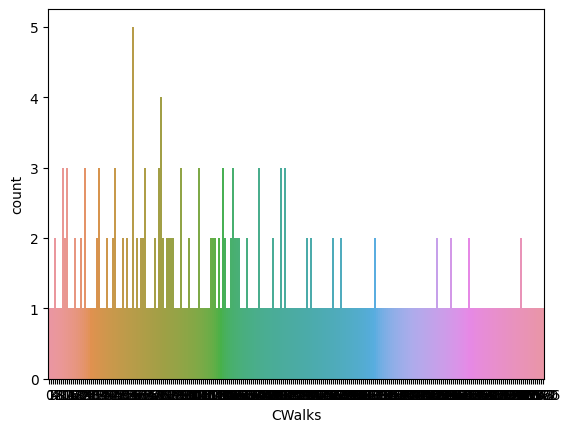

     PutOuts     Ratio
0         15  4.658385
325        5  1.552795
303        4  1.242236
102        4  1.242236
211        4  1.242236
..       ...       ...
207        1  0.310559
670        1  0.310559
331        1  0.310559
295        1  0.310559
408        1  0.310559

[232 rows x 2 columns]
----------------------------------------


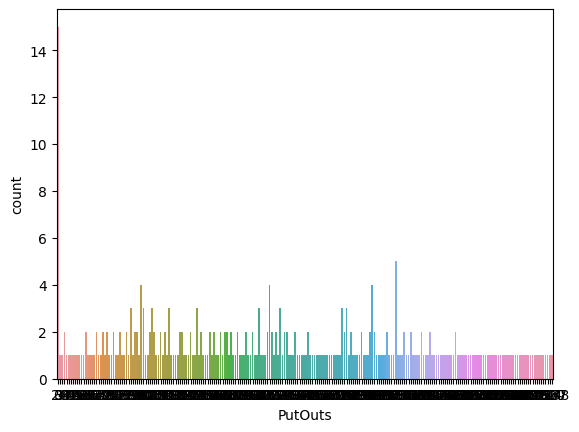

     Assists     Ratio
0         19  5.900621
9         15  4.658385
2         12  3.726708
5         11  3.416149
6         10  3.105590
..       ...       ...
41         1  0.310559
132        1  0.310559
327        1  0.310559
156        1  0.310559
131        1  0.310559

[161 rows x 2 columns]
----------------------------------------


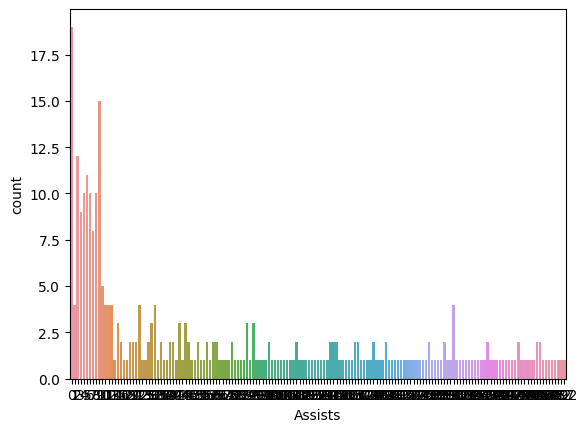

    Errors      Ratio
3       33  10.248447
4       28   8.695652
5       26   8.074534
6       23   7.142857
2       21   6.521739
0       21   6.521739
8       20   6.211180
7       18   5.590062
9       18   5.590062
1       13   4.037267
10      12   3.726708
16      11   3.416149
13      10   3.105590
11      10   3.105590
15       9   2.795031
20       7   2.173913
12       6   1.863354
14       6   1.863354
19       5   1.552795
18       5   1.552795
17       5   1.552795
25       4   1.242236
22       3   0.931677
23       2   0.621118
26       2   0.621118
24       1   0.310559
21       1   0.310559
29       1   0.310559
32       1   0.310559
----------------------------------------


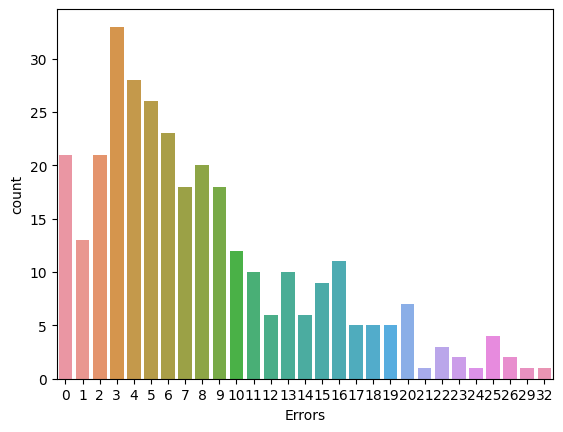

         Salary     Ratio
750.00        8  2.484472
100.00        6  1.863354
250.00        6  1.863354
90.00         6  1.863354
700.00        5  1.552795
...         ...       ...
490.00        1  0.310559
1861.46       1  0.310559
595.00        1  0.310559
1220.00       1  0.310559
960.00        1  0.310559

[150 rows x 2 columns]
----------------------------------------


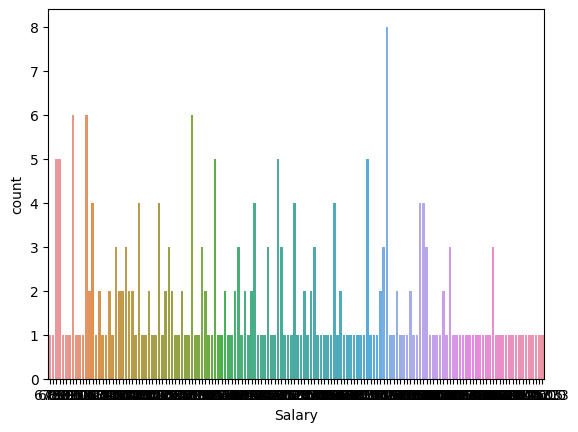

In [175]:
def cat_summary(dataframe, col_name, plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("----------------------------------------")
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show(block=True)

for col in num_cols:
  cat_summary(df, col, True)

count    322.000000
mean     380.928571
std      153.404981
min       16.000000
5%       161.000000
10%      194.100000
20%      221.800000
30%      281.300000
40%      321.800000
50%      379.500000
60%      430.200000
70%      490.000000
80%      535.600000
90%      584.900000
95%      609.900000
99%      658.590000
max      687.000000
Name: AtBat, dtype: float64


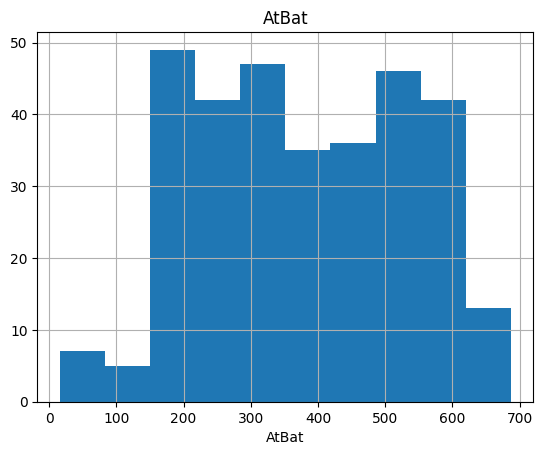

count    322.000000
mean     101.024845
std       46.454741
min        1.000000
5%        39.000000
10%       45.100000
20%       57.000000
30%       70.000000
40%       82.000000
50%       96.000000
60%      113.000000
70%      128.700000
80%      144.000000
90%      163.000000
95%      174.000000
99%      210.790000
max      238.000000
Name: Hits, dtype: float64


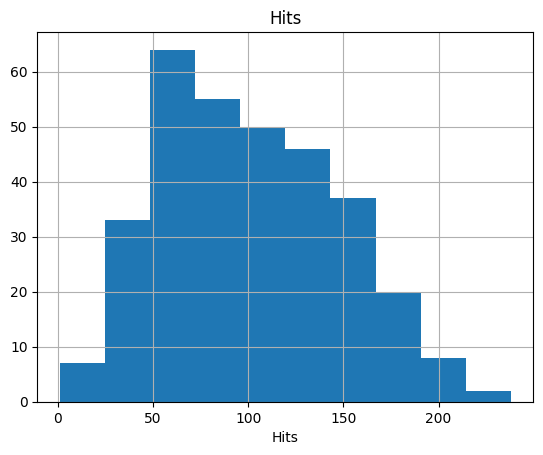

count    322.000000
mean      10.770186
std        8.709037
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        5.000000
40%        6.000000
50%        8.000000
60%       10.600000
70%       14.000000
80%       18.000000
90%       24.000000
95%       28.950000
99%       33.000000
max       40.000000
Name: HmRun, dtype: float64


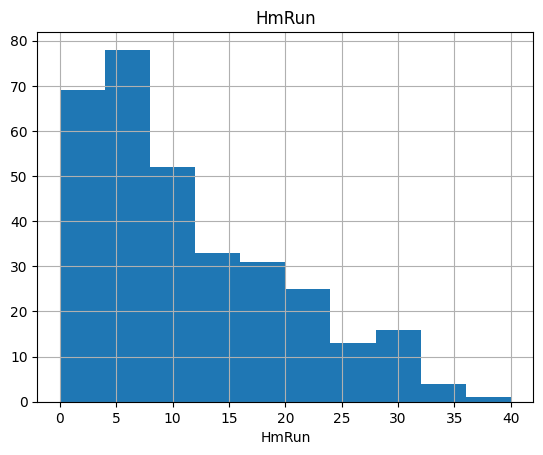

count    322.000000
mean      50.909938
std       26.024095
min        0.000000
5%        17.000000
10%       20.100000
20%       27.000000
30%       33.000000
40%       41.000000
50%       48.000000
60%       55.600000
70%       66.000000
80%       75.800000
90%       89.000000
95%       94.000000
99%      107.790000
max      130.000000
Name: Runs, dtype: float64


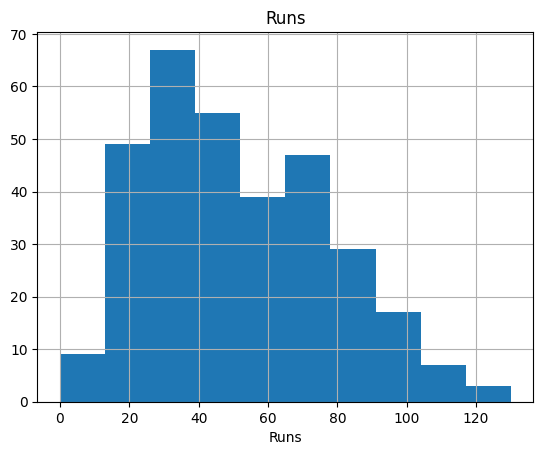

count    322.000000
mean      48.027950
std       26.166895
min        0.000000
5%        14.000000
10%       19.000000
20%       26.000000
30%       30.000000
40%       36.400000
50%       44.000000
60%       49.000000
70%       58.000000
80%       73.000000
90%       86.000000
95%       96.000000
99%      112.370000
max      121.000000
Name: RBI, dtype: float64


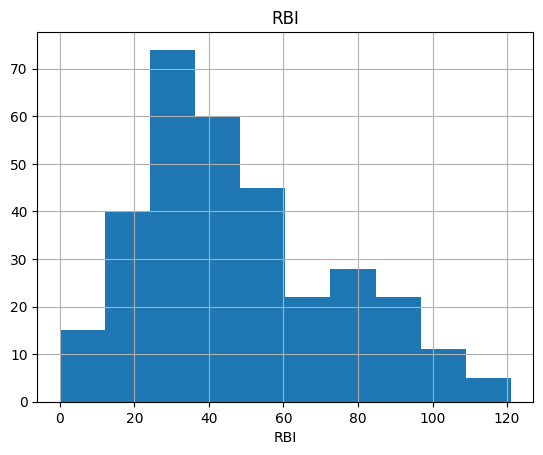

count    322.000000
mean      38.742236
std       21.639327
min        0.000000
5%        11.050000
10%       15.000000
20%       20.000000
30%       24.000000
40%       30.000000
50%       35.000000
60%       40.000000
70%       48.700000
80%       59.000000
90%       69.900000
95%       78.000000
99%       93.580000
max      105.000000
Name: Walks, dtype: float64


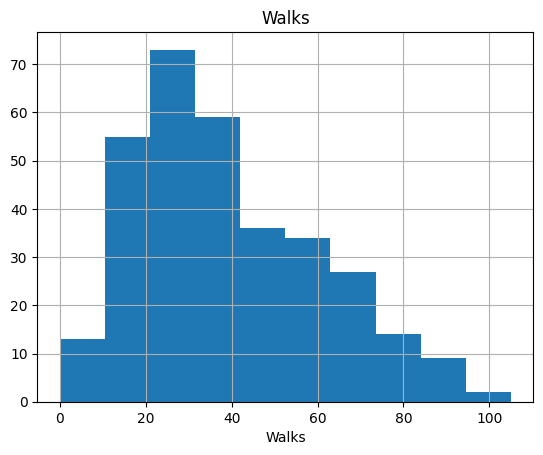

count    322.000000
mean       7.444099
std        4.926087
min        1.000000
5%         1.000000
10%        2.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        7.600000
70%       10.000000
80%       12.000000
90%       15.000000
95%       17.000000
99%       19.790000
max       24.000000
Name: Years, dtype: float64


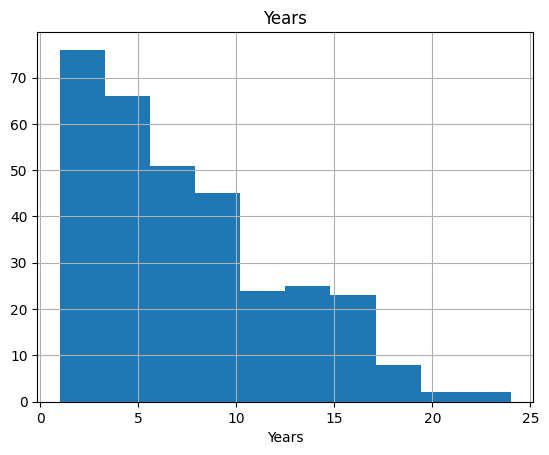

count      322.00000
mean      2648.68323
std       2324.20587
min         19.00000
5%         216.50000
10%        342.20000
20%        667.60000
30%        963.40000
40%       1402.20000
50%       1928.00000
60%       2654.00000
70%       3365.00000
80%       4483.00000
90%       6123.40000
95%       7125.60000
99%       8749.97000
max      14053.00000
Name: CAtBat, dtype: float64


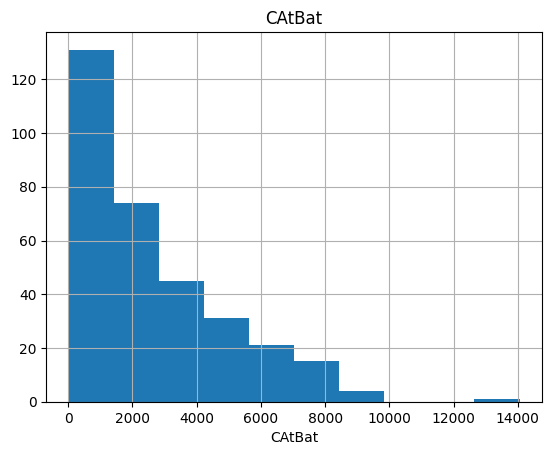

count     322.000000
mean      717.571429
std       654.472627
min         4.000000
5%         54.000000
10%        86.000000
20%       164.600000
30%       238.000000
40%       355.800000
50%       508.000000
60%       708.200000
70%       911.100000
80%      1229.200000
90%      1659.600000
95%      2017.150000
99%      2500.340000
max      4256.000000
Name: CHits, dtype: float64


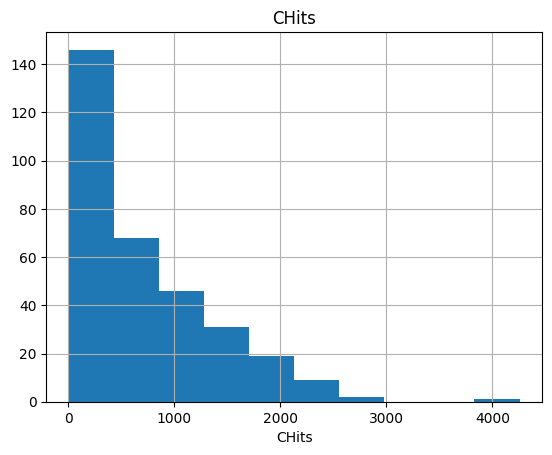

count    322.000000
mean      69.490683
std       86.266061
min        0.000000
5%         2.000000
10%        4.000000
20%       10.200000
30%       16.300000
40%       27.400000
50%       37.500000
60%       51.200000
70%       72.400000
80%      103.800000
90%      194.900000
95%      265.650000
99%      373.120000
max      548.000000
Name: CHmRun, dtype: float64


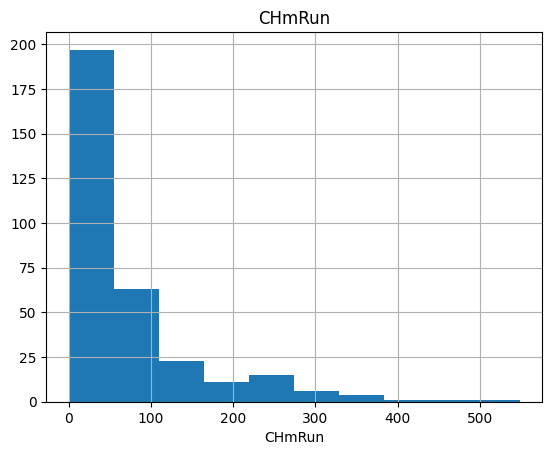

count     322.000000
mean      358.795031
std       334.105886
min         1.000000
5%         27.000000
10%        38.100000
20%        80.400000
30%       117.300000
40%       181.000000
50%       247.000000
60%       333.000000
70%       443.400000
80%       627.200000
90%       895.700000
95%      1032.300000
99%      1174.370000
max      2165.000000
Name: CRuns, dtype: float64


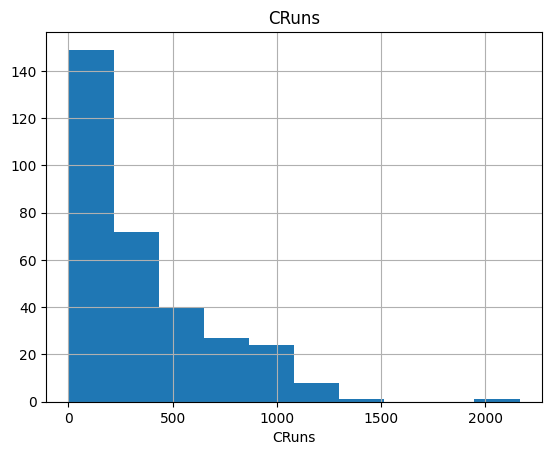

count     322.000000
mean      330.118012
std       333.219617
min         0.000000
5%         22.050000
10%        34.100000
20%        70.200000
30%       106.300000
40%       149.000000
50%       220.500000
60%       303.600000
70%       379.100000
80%       496.200000
90%       861.600000
95%      1071.750000
99%      1310.850000
max      1659.000000
Name: CRBI, dtype: float64


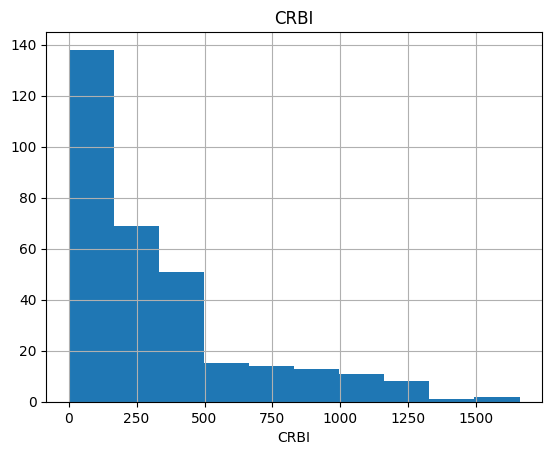

count     322.000000
mean      260.239130
std       267.058085
min         0.000000
5%         15.050000
10%        30.100000
20%        55.000000
30%        82.000000
40%       117.400000
50%       170.500000
60%       226.600000
70%       300.700000
80%       421.000000
90%       643.900000
95%       817.600000
99%      1139.140000
max      1566.000000
Name: CWalks, dtype: float64


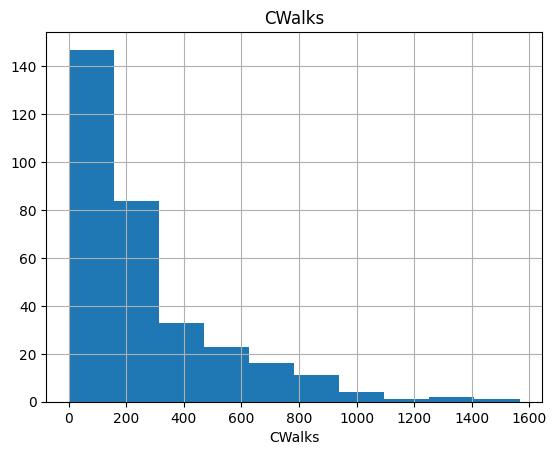

count     322.000000
mean      288.937888
std       280.704614
min         0.000000
5%         33.200000
10%        62.200000
20%        99.600000
30%       132.000000
40%       167.000000
50%       212.000000
60%       257.400000
70%       303.000000
80%       365.800000
90%       685.600000
95%       910.650000
99%      1301.190000
max      1378.000000
Name: PutOuts, dtype: float64


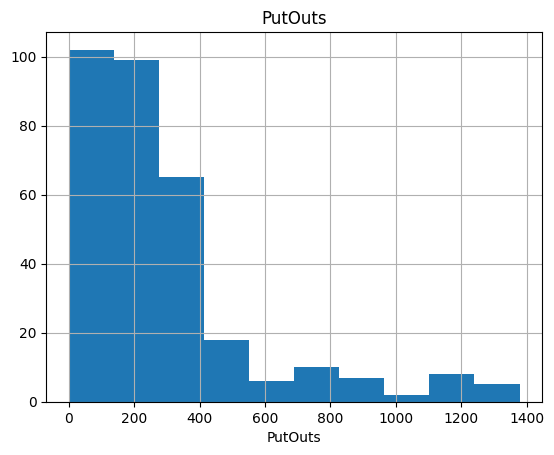

count    322.000000
mean     106.913043
std      136.854876
min        0.000000
5%         0.000000
10%        2.000000
20%        5.200000
30%        9.000000
40%       15.400000
50%       39.500000
60%       76.800000
70%      134.800000
80%      210.800000
90%      353.300000
95%      431.450000
99%      478.160000
max      492.000000
Name: Assists, dtype: float64


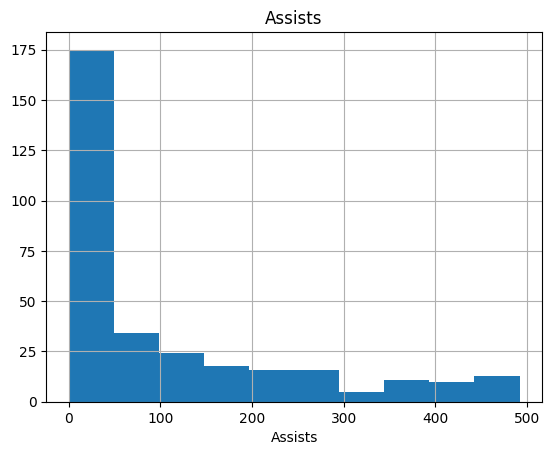

count    322.000000
mean       8.040373
std        6.368359
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        8.000000
70%       10.000000
80%       13.000000
90%       17.000000
95%       20.000000
99%       25.790000
max       32.000000
Name: Errors, dtype: float64


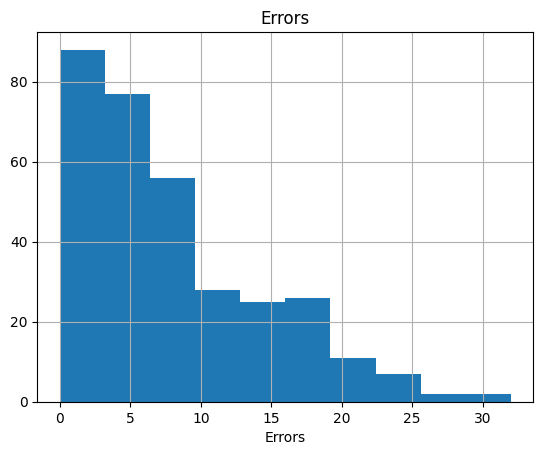

count     263.000000
mean      535.925882
std       451.118681
min        67.500000
5%         86.600000
10%       100.000000
20%       155.000000
30%       221.000000
40%       300.000000
50%       425.000000
60%       538.000000
70%       700.000000
80%       809.000000
90%      1048.666600
95%      1346.000000
99%      2032.886540
max      2460.000000
Name: Salary, dtype: float64


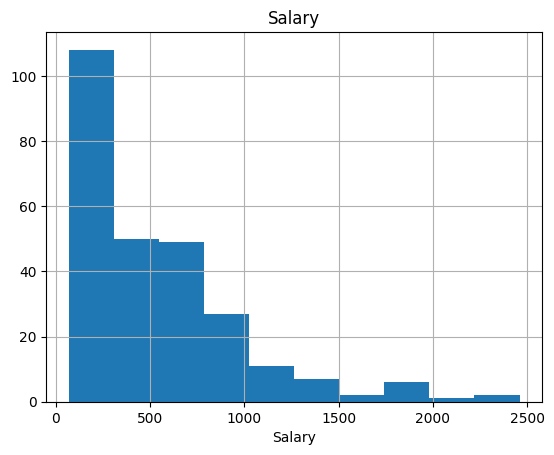

In [176]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist()
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

for col in num_cols:
  num_summary(df, col, True)

Target variable analysis.

In [177]:
def target_summary_cat(dataframe, target, cat_col):
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(cat_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
  target_summary_cat(df, "Salary", col)

        TARGET_MEAN
League             
A        541.999547
N        529.117500


          TARGET_MEAN
Division             
E          624.271364
W          450.876873


           TARGET_MEAN
NewLeague             
A           537.113028
N           534.553852




In [178]:
def target_summary_num(dataframe, target, num_col):
  print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n")

for col in num_cols:
  target_summary_num(df, "Salary", col)

          AtBat
Salary         
67.500    181.0
68.000    209.0
70.000    248.6
75.000    236.4
80.000    399.0
...         ...
1940.000  514.0
1975.000  677.0
2127.333   20.0
2412.500  618.0
2460.000  495.0

[150 rows x 1 columns]


           Hits
Salary         
67.500     41.0
68.000     54.0
70.000     57.4
75.000     58.2
80.000    102.0
...         ...
1940.000  144.0
1975.000  238.0
2127.333    1.0
2412.500  200.0
2460.000  151.0

[150 rows x 1 columns]


          HmRun
Salary         
67.500      1.0
68.000      3.0
70.000      3.2
75.000      3.0
80.000      3.0
...         ...
1940.000    0.0
1975.000   31.0
2127.333    0.0
2412.500   20.0
2460.000   17.0

[150 rows x 1 columns]


           Runs
Salary         
67.500     15.0
68.000     25.0
70.000     27.8
75.000     25.2
80.000     56.0
...         ...
1940.000   67.0
1975.000  117.0
2127.333    0.0
2412.500   98.0
2460.000   61.0

[150 rows x 1 columns]


            RBI
Salary         
67.500     21.0
68.000     14.0


Outlier analysis.

In [179]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  iqr = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * iqr
  low_limit = quartile1 - 1.5 * iqr

  return up_limit, low_limit

def check_outliers(dataframe, col_name):
  up, low = outlier_thresholds(dataframe, col_name)

  if dataframe[(dataframe[col_name] > up) | (dataframe[col_name] < low)].any(axis=None):
    return True
  else:
    return False

for col in num_cols:
  print(col, check_outliers(df, col))

AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


Missing variable analysis.

In [181]:
def missing_values(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")

  if na_name:
    return na_columns
na_columns = missing_values(df, True)

        n_miss  ratio
Salary      59  18.32


In [182]:
def missing_vs_target(dataframe, target, na_columns):
  temp_df = dataframe.copy()

  for col in na_columns:
    temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1,0)

  na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

  for col in na_flags:
    print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(), "Count": temp_df.groupby(col)[target]}), end="\n\n")

missing_vs_target(df, "Salary", na_columns)

                TARGET_MEAN                                              Count
Salary_NA_FLAG                                                                
0                535.925882  (0, [475.0, 480.0, 500.0, 91.5, 750.0, 70.0, 1...
1                       NaN  (1, [nan, nan, nan, nan, nan, nan, nan, nan, n...



Handling missing variables with imputing.

In [183]:
def label_encoder(dataframe, cat_col):
  le = LabelEncoder()
  dataframe[cat_col] = le.fit_transform(dataframe[cat_col])
  return dataframe

for col in cat_cols:
  df = label_encoder(df, col)

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)

df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,0.0,0.0,446.0,33.0,20.0,116.5,0.0
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,1.0,1.0,632.0,43.0,10.0,475.0,1.0
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,0.0,1.0,880.0,82.0,14.0,480.0,0.0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,1.0,0.0,200.0,11.0,3.0,500.0,1.0
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,1.0,0.0,805.0,40.0,4.0,91.5,1.0


Analyzing outliers with LOF and removing them.

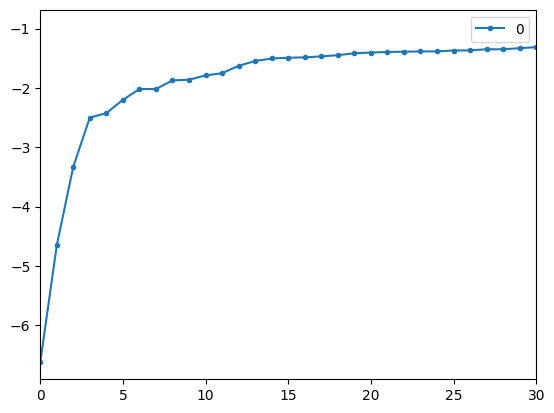

In [184]:
numeric = df[num_cols]
lof = LocalOutlierFactor(n_neighbors=20)
lof.fit_predict(numeric)

df_scores = lof.negative_outlier_factor_
df_scores[0:5]
np.sort(df_scores)[0:5]

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0,30], style='.-')
plt.show()

In [185]:
print(df.shape)
th = np.sort(df_scores)[5]
print(df[df_scores < th].index)
df.drop(axis=0, labels=df[df_scores < th].index, inplace=True)
print(df.shape)

(322, 20)
Int64Index([217, 236, 274, 295, 315], dtype='int64')
(317, 20)


Creating new variables.

In [186]:
# Experience level
df.loc[(df["Years"] <= 2), "EXPERIENCE_LEVEL"] = "Junior"
df.loc[(df["Years"] > 2) & (df["Years"] <= 5), "EXPERIENCE_LEVEL"] = "Mid"
df.loc[(df["Years"] > 5) & (df["Years"] <= 10), "EXPERIENCE_LEVEL"] = "Senior"
df.loc[(df["Years"] > 10), "EXPERIENCE_LEVEL"] = "Expert"

# Ratio of variables
df["C_RUNS_RATIO"] = df["Runs"] / df["CRuns"]
df["C_ATBAT_RATIO"] = df["AtBat"] / df["CAtBat"]
df["C_HITS_RATIO"] = df["Hits"] / df["CHits"]
df["C_HIT_RATE"] = df["CHits"] / df["CAtBat"]
df["C_RUNNER"] = df["CRBI"] / df["CHits"]
df["C_HIT_AND_RUN"] = df["CRuns"] / df["CHits"]
df["C_HMHITS_RATIO"] = df["CHmRun"] / df["CHits"]

#Mean of variables
df["CATBAT_MEAN"] = df["CAtBat"] / df["Years"]
df["CHITS_MEAN"] = df["CHits"] / df["Years"]
df["CHMRUN_MEAN"] = df["CHmRun"] / df["Years"]
df["CRUNS_MEAN"] = df["CRuns"] / df["Years"]
df["CRBI_MEAN"] = df["CRBI"] / df["Years"]
df["CWALKS_MEAN"] = df["CWalks"] / df["Years"]

# Experience X Division
df.loc[(df["EXPERIENCE_LEVEL"] == "Junior") & (df["Division"] == 0), 'YEAR_DIV_CAT'] = "Junior-East"
df.loc[(df["EXPERIENCE_LEVEL"] == "Junior") & (df["Division"] == 1), 'YEAR_DIV_CAT'] = "Junior-West"
df.loc[(df["EXPERIENCE_LEVEL"] == "Mid") & (df["Division"] == 0), 'YEAR_DIV_CAT'] = "Mid-East"
df.loc[(df["EXPERIENCE_LEVEL"] == "Mid") & (df["Division"] == 1), 'YEAR_DIV_CAT'] = "Mid-West"
df.loc[(df["EXPERIENCE_LEVEL"] == "Senior") & (df["Division"] == 0), 'YEAR_DIV_CAT'] = "Senior-East"
df.loc[(df["EXPERIENCE_LEVEL"] == "Senior") & (df["Division"] == 1), 'YEAR_DIV_CAT'] = "Senior-West"
df.loc[(df["EXPERIENCE_LEVEL"] == "Expert") & (df["Division"] == 0), 'YEAR_DIV_CAT'] = "Expert-East"
df.loc[(df["EXPERIENCE_LEVEL"] == "Expert") & (df["Division"] == 1), 'YEAR_DIV_CAT'] = "Expert-West"

# Player progress
df.loc[(df["League"] == 1) & (df["NewLeague"] == 1), "PLAYER_PROGRESS"] = "StandN"
df.loc[(df["League"] == 0) & (df["NewLeague"] == 0), "PLAYER_PROGRESS"] = "StandA"
df.loc[(df["League"] == 1) & (df["NewLeague"] == 0), "PLAYER_PROGRESS"] = "Descend"
df.loc[(df["League"] == 0) & (df["NewLeague"] == 1), "PLAYER_PROGRESS"] = "Ascend"

# PLayer Ratio in year
df["ASSISTS_RATIO"] = df["Assists"] / df["AtBat"]
df["HITS_RECALL"] = df["Hits"] / (df["Hits"] + df["Errors"])
df["TOTAL_SCORE"] = (df["RBI"] + df["Assists"] + df["Walks"] - df["Errors"]) / df["AtBat"]
df["HIT_RATE"] = df["Hits"] / df["AtBat"]
df["RUNNER"] = df["RBI"] / df["Hits"]
df["HIT-AND-RUN"] = df["Runs"] / (df["Hits"])
df["TOTAL_CHANCES"] = df["Errors"] + df["PutOuts"] + df["Assists"]

df = df.drop(['AtBat','Hits','HmRun','Runs','RBI','Walks'], axis=1)
cat_cols, num_cols, cat_but_car = grab_col_names(df)
df.head()


Observations: 317
Variables: 37
cat_cols: 6
num_cols: 31
cat_but_car: 0
num_but_cat: 3


,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,...,CWALKS_MEAN,YEAR_DIV_CAT,PLAYER_PROGRESS,ASSISTS_RATIO,HITS_RECALL,TOTAL_SCORE,HIT_RATE,RUNNER,HIT-AND-RUN,TOTAL_CHANCES
0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,0.0,0.0,446.0,...,14.000000,Junior-East,StandA,0.112628,0.767442,0.191126,0.225256,0.439394,0.454545,499.0
1,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,1.0,1.0,632.0,...,26.785714,Expert-West,StandN,0.136508,0.890110,0.349206,0.257143,0.469136,0.296296,685.0
2,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,0.0,1.0,880.0,...,87.666667,Mid-West,StandA,0.171190,0.902778,0.450939,0.271399,0.553846,0.507692,976.0
3,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,1.0,0.0,200.0,...,32.181818,Expert-East,StandN,0.022177,0.979167,0.247984,0.284274,0.553191,0.460993,214.0
4,2.0,396.0,101.0,12.0,48.0,46.0,33.0,1.0,0.0,805.0,...,16.500000,Junior-East,StandN,0.124611,0.956044,0.336449,0.271028,0.482759,0.448276,849.0


Applying one hot encoder to categorical columns.

In [187]:
new_cat_cols = [col for col in df.columns if df[col].dtypes == "object"]
new_cat_cols

def one_hot_encoder(dataframe, cat_cols, drop_first=True):
  dataframe = pd.get_dummies(dataframe, cat_cols, drop_first=drop_first)
  return dataframe

df = one_hot_encoder(df, new_cat_cols)

Applying Min Max Scaler to numerical columns.

In [188]:
mms = MinMaxScaler()
df[num_cols] = mms.fit_transform(df[num_cols])

Modelling

In [189]:
X = df.drop("Salary", axis=1)
y = df["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)
lr = LinearRegression().fit(X_train,y_train)

print("R-SQUARE:",lr.score(X, y))
y_pred = lr.predict(X)
print("MAE: ",mean_absolute_error(y, y_pred))
print("MSE: ", mean_squared_error(y, y_pred))
print("Standart deviation: ",y.std())
print("Mean: ", y.mean())
print("RMSE: ", np.sqrt(mean_squared_error(y, y_pred)))
print("10 CV RMSE: ",np.mean(np.sqrt(-cross_val_score(lr,
                                 X,
                                 y,
                                 cv=10,
                                 scoring="neg_mean_squared_error"))))

R-SQUARE: 0.707671490010006
MAE:  0.06780132674167248
MSE:  0.008940437307966176
Standart deviation:  0.17515796238900294
Mean:  0.1820961706700421
RMSE:  0.09455388573700277
10 CV RMSE:  0.10453853109624509
